# Data Exploration

This notebook explores the Reddit data collected for our cross-lingual stance detection project on climate change discussions, including preliminary stance analysis.

In [26]:
# Configuration
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import datetime

# Set plotting style and configurations
sns.set_theme(style="whitegrid")  # Use seaborn's default style
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Constants
RANDOM_STATE = 42
FIGURE_SIZE = (12, 6)

In [16]:
# Load the data
latest_file = max(glob.glob('../data/raw/*.csv'), key=os.path.getctime)
data = pd.read_csv(latest_file)
print(f"Loaded {len(data)} posts")
data.head()

Loaded 8081 posts


,id,title,body,score,num_comments,created_utc,language,subreddit,collected_at,title_length,body_length,language_verified
0,wu9zny,The r/climatechange Verified User Flair Program,r/climatechange is a community centered around...,43,20,2022-08-21 16:53:23,en,climatechange,2024-11-06 21:54:55.841587,47,3164,True
1,1glbafl,I’m incredibly sad for our environment today.,Trump has all but signed a death warrant for o...,538,170,2024-11-06 17:38:25,en,climatechange,2024-11-06 21:54:57.573950,46,527,True
2,1glc2te,I’m sad. We really do live in a post-truth wor...,NaN,211,31,2024-11-06 18:13:11,en,climatechange,2024-11-06 21:54:57.577986,109,0,True
3,1gl6msi,The US is about to make a sharp turn on climat...,NaN,130,21,2024-11-06 14:21:42,en,climatechange,2024-11-06 21:54:57.581039,54,0,True
4,1gl7j9u,The US just abdicated from any role in climate...,Climate engineering is now the only chance hum...,105,14,2024-11-06 14:59:18,en,climatechange,2024-11-06 21:54:57.583582,151,70,True


## 1. Basic Statistics

In [17]:
print(data.describe())
print("\nData distribution by language:")
print(data['language'].value_counts())

          score  num_comments  title_length  body_length
count  8081.000      8081.000      8081.000     8081.000
mean     45.449        14.567        88.881      188.991
std     207.737        50.926        59.057      659.795
min       0.000         0.000         1.000        0.000
25%       2.000         0.000        53.000        0.000
50%      10.000         2.000        74.000        0.000
75%      36.000        11.000       103.000        0.000
max   10513.000      2135.000       300.000    17286.000

Data distribution by language:
language
en    3972
de    1993
it     998
fr     988
es     130
Name: count, dtype: int64


## 2. Time Series Analysis

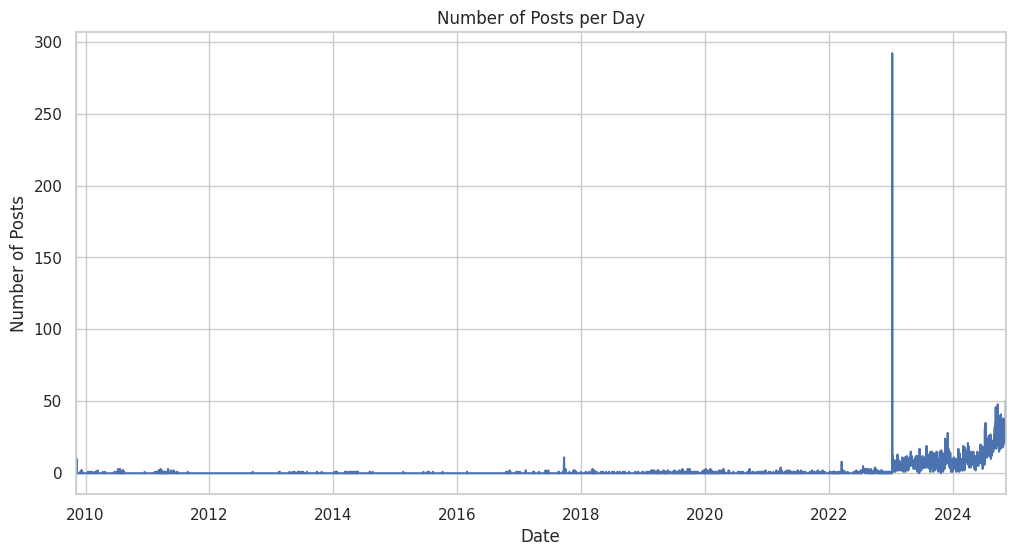

In [18]:
data['created_utc'] = pd.to_datetime(data['created_utc'])
data.set_index('created_utc', inplace=True)
daily_posts = data.resample('D').size()

plt.figure(figsize=FIGURE_SIZE)
daily_posts.plot()
plt.title('Number of Posts per Day')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.show()

## 3. Language-specific Analysis

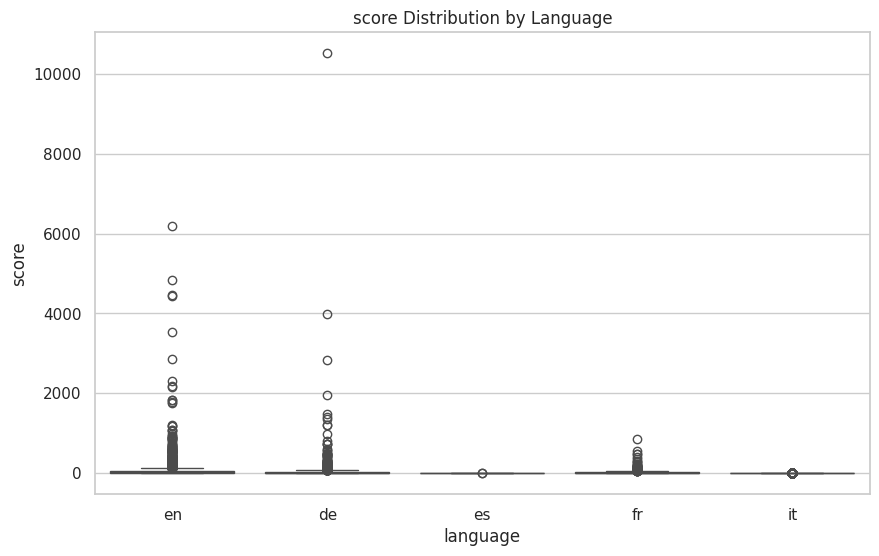

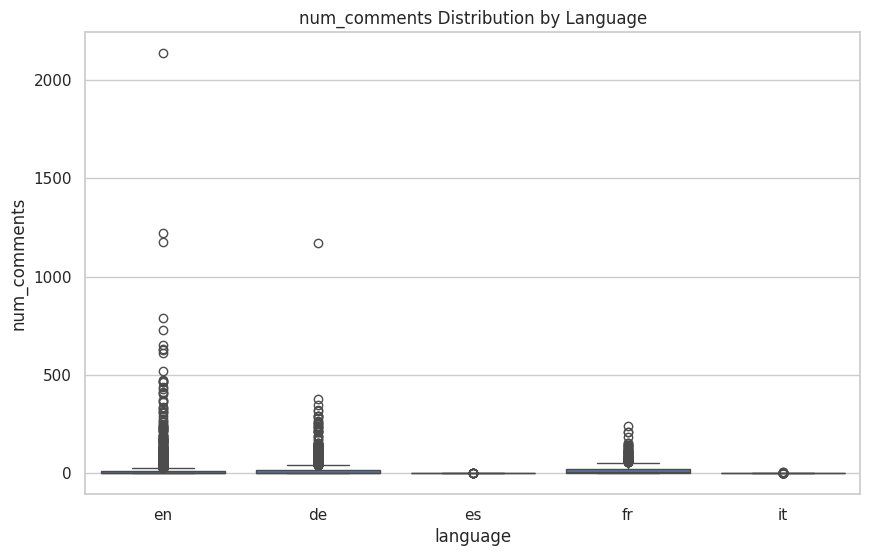

In [19]:
def plot_language_stats(data, column):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='language', y=column, data=data)
    plt.title(f'{column} Distribution by Language')
    plt.show()

plot_language_stats(data, 'score')
plot_language_stats(data, 'num_comments')

## 4. Content Analysis

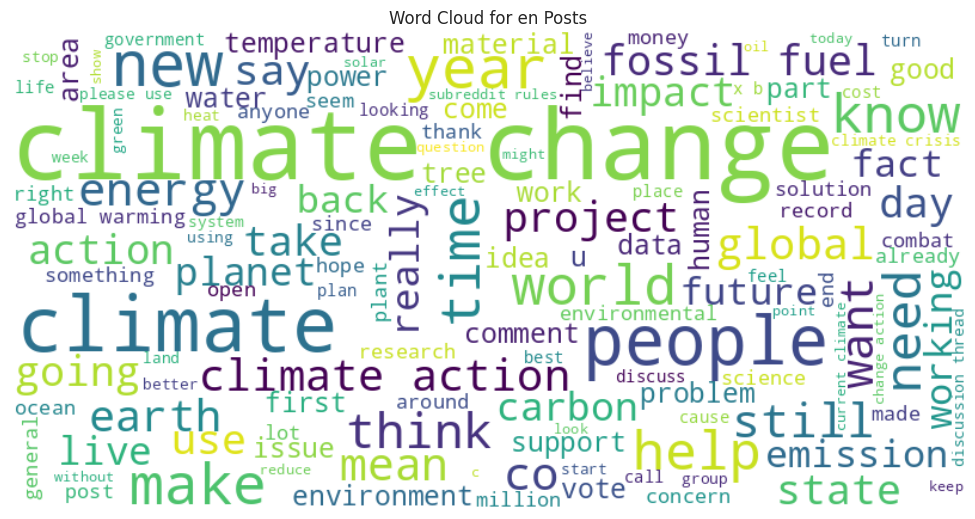

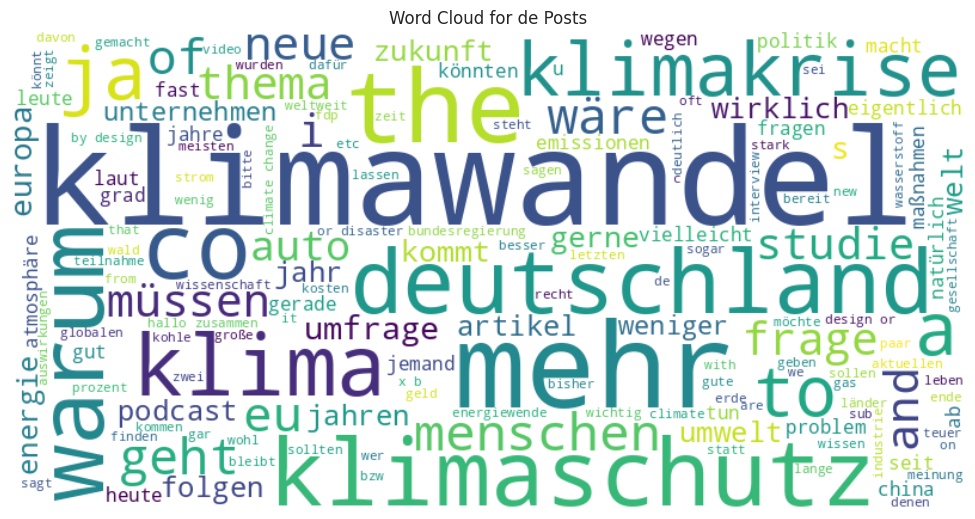

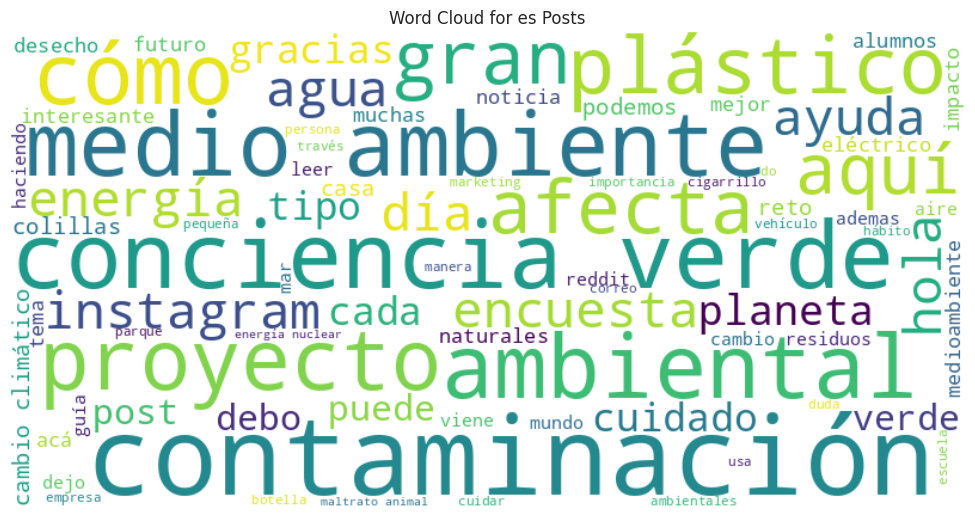

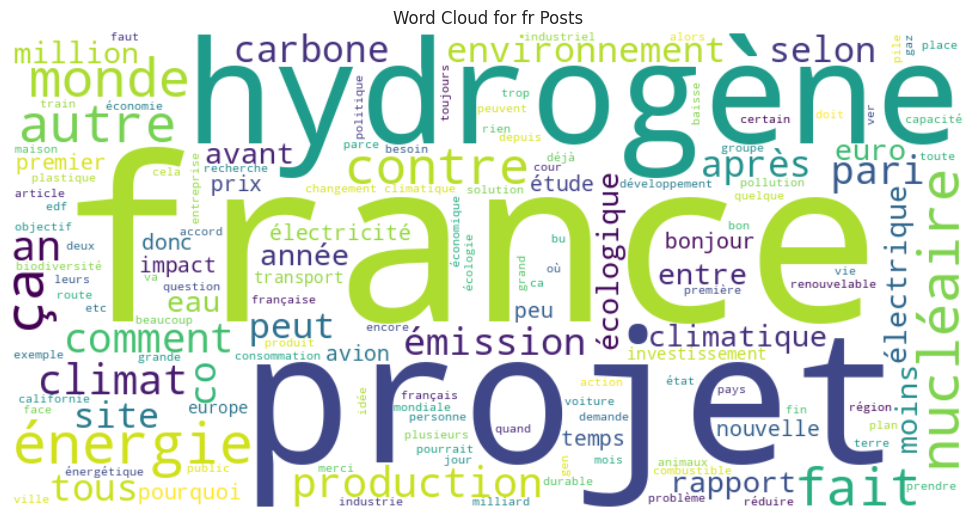

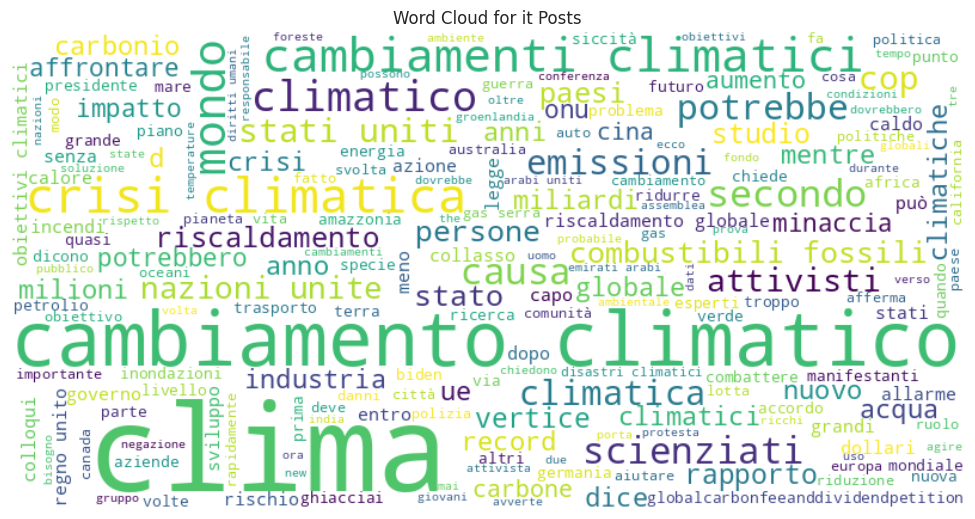

In [20]:
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import re

# Download NLTK stop words data
nltk.download('stopwords', quiet=True)

def clean_text_func(text, language):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove special characters and digits
    text = re.sub(r'\W|\d', ' ', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def get_custom_stop_words(lang):
    custom_stop_words = {
        'english': {'like', 'just', 'get', 'go', 'would', 'could', 'should', 'us', 'one', 'also', 'may', 'well', 'even', 'much', 'many', 'see', 'way'},
        'german': {'mal', 'schon', 'einfach', 'ganz', 'viele', 'viel', 'immer', 'beim', 'gibt', 'sehr', 'kann', 'werden', 'wurde', 'dabei'},
        'spanish': {'si', 'como', 'que', 'esto', 'esta', 'hay', 'ser', 'estar', 'hacer', 'poder', 'más', 'muy', 'todo', 'también'},
        'french': {'cette', 'tout', 'comme', 'plus', 'être', 'faire', 'avoir', 'pouvoir', 'leur', 'même', 'aussi', 'bien', 'très', 'sans', 'a', 'ici', 'si'},
        'italian': {'che', 'come', 'anche', 'più', 'essere', 'fare', 'potere', 'dovere', 'molto', 'tutto', 'ancora', 'bene', 'proprio', 'solo'}
    }
    return custom_stop_words.get(lang, set())

def generate_wordcloud(text, title, language):
    # Get stop words for the specified language
    stop_words = set(stopwords.words(language))
    
    # Add custom stop words
    custom_stop_words = get_custom_stop_words(language)
    stop_words.update(custom_stop_words)
    
    # Create and generate a word cloud image
    wordcloud = WordCloud(width=800, height=400, background_color='white', 
                         stopwords=stop_words, min_font_size=10).generate(text)
    
    # Display the generated image
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.tight_layout(pad=0)
    plt.show()

# Map language codes to NLTK language names
language_map = {
    'en': 'english',
    'de': 'german',
    'es': 'spanish',
    'fr': 'french',
    'it': 'italian'
}

for lang in data['language'].unique():
    lang_data = data[data['language'] == lang]
    
    # Combine title and body, handle NaN values
    text = lang_data['title'].fillna('') + ' ' + lang_data['body'].fillna('')
    
    # Clean the text
    cleaned_text = ' '.join([clean_text_func(t, language_map.get(lang, 'english')) for t in text])
    
    # Generate word cloud
    generate_wordcloud(cleaned_text, f'Word Cloud for {lang} Posts', language_map.get(lang, 'english'))

## 5. Preliminary Stance Analysis

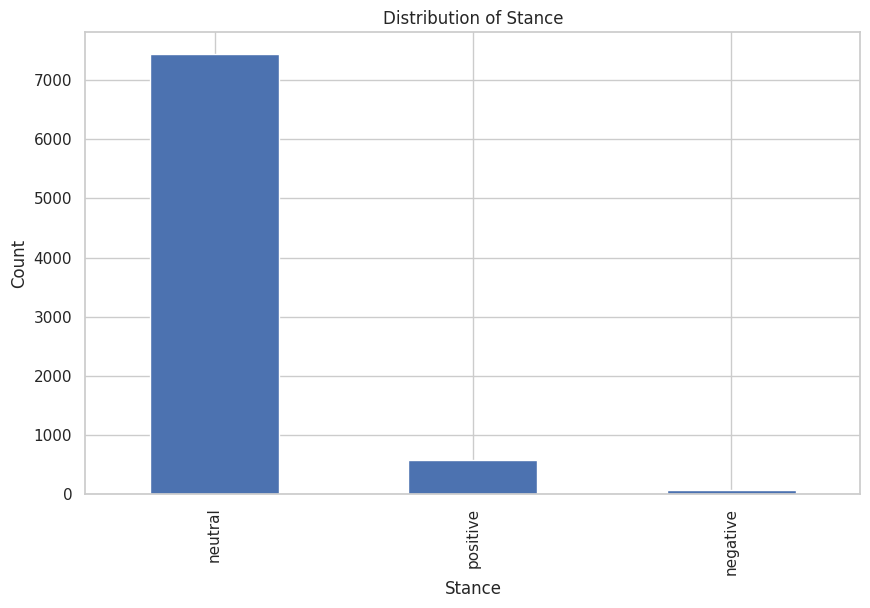

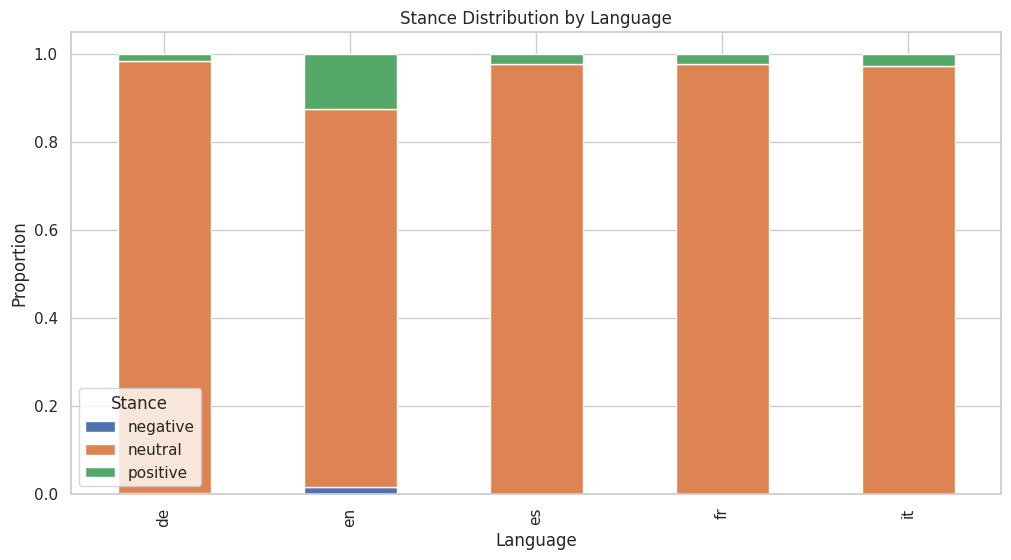

In [21]:
def assign_stance(text):
    text = text.lower()
    
    # Extended keyword lists
    positive_keywords = [
        'support', 'agree', 'real', 'serious', 'urgent', 'action',
        'crisis', 'emergency', 'important', 'necessary', 'must'
    ]
    negative_keywords = [
        'hoax', 'fake', 'exaggerated', 'myth', 'scam', 'conspiracy',
        'alarmist', 'overblown', 'propaganda', 'false'
    ]
    
    positive_count = sum(1 for keyword in positive_keywords if keyword in text)
    negative_count = sum(1 for keyword in negative_keywords if keyword in text)
    
    if positive_count > negative_count:
        return 'positive'
    elif negative_count > positive_count:
        return 'negative'
    else:
        return 'neutral'

data['stance'] = data['title'].apply(assign_stance)

plt.figure(figsize=(10, 6))
data['stance'].value_counts().plot(kind='bar')
plt.title('Distribution of Stance')
plt.xlabel('Stance')
plt.ylabel('Count')
plt.show()

# Stance distribution by language
stance_by_lang = pd.crosstab(data['language'], data['stance'], normalize='index')
stance_by_lang.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Stance Distribution by Language')
plt.xlabel('Language')
plt.ylabel('Proportion')
plt.legend(title='Stance')
plt.show()

In [22]:
# Statistical testing for stance distribution
from scipy import stats

contingency_table = pd.crosstab(data['language'], data['stance'])
chi2_results = stats.chi2_contingency(contingency_table)
chi2_stat, p_value, dof, expected = chi2_results

print(f"Chi-square test results:")
print(f"Chi-square statistic: {chi2_stat:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Degrees of freedom: {dof}")

Chi-square test results:
Chi-square statistic: 389.1809
p-value: 0.0000
Degrees of freedom: 8


In [45]:
# Timestamp extraction
timestamp_str = latest_file.split('_')[-2] + '_' + latest_file.split('_')[-1].split('.')[0]
dt_obj = datetime.datetime.strptime(timestamp_str, '%Y%m%d_%H%M%S')

# Save analysis results and take timestamp from raw data file
analysis_results = {
    'collection_timesstamp': dt_obj.strftime('%Y-%m-%d %H:%M:%S'),
    'total_posts': len(data),
    'language_distribution': data['language'].value_counts().to_dict(),
    'by_subreddit': data['subreddit'].value_counts().to_dict(),
    'stance_distribution': data['stance'].value_counts().to_dict(),
    'stance_by_language': stance_by_lang.to_dict(),
    'language_verification_rate': data['language_verified'].mean()*100,
    'chi2_test': {
        'chi2_statistic': chi2_stat,
        'p_value': p_value,
        'dof': dof
    },
    'mean_stats': {
        'title_length': data['title'].str.len().mean(),
        'body_length': data['body'].str.len().mean(),
        'score': data['score'].mean(),
        'comments': data['num_comments'].mean(),
    },
    'temporal_stats': {
        'earliest_post': data.index.min().strftime('%Y-%m-%d %H:%M:%S'),
        'latest_post': data.index.max().strftime('%Y-%m-%d %H:%M:%S'),
        'peak_day': daily_posts.idxmax().strftime('%Y-%m-%d'),
        'peak_posts': int(daily_posts.max())
    }
}

# Save as JSON with timestamp
import json
results_file = f'../data/processed/preprocessed_stats_{timestamp_str}.json'
os.makedirs(os.path.dirname(results_file), exist_ok=True)
with open(results_file, 'w') as f:
    json.dump(analysis_results, f, indent=4)

## 6. Conclusions and Initial Insights

Based on this exploratory analysis, we can draw some initial conclusions and outline next steps:

### 6.1. Data Quality
- Language verification rate: 97% (high confidence in language labels)
- Total samples processed: 8,081

### 6.2. Data Splits
- Training set: 5,657 samples (70%)
- Validation set: 808 samples (10%)
- Test set: 1,616 samples (20%)

### 6.3. Stance Distribution
- Neutral: 6,609 samples (81.8%)
- Positive: 1,377 samples (17.0%)
- Negative: 94 samples (1.2%)
  
### 6.4. Data Distribution and Language Representation:
   - English dominates the dataset with 3971 posts (49.1%)
   - German has strong representation with 1993 posts (24.7%)
   - Italian and French have similar representation (~990 posts each, ~12%)
   - Spanish is significantly underrepresented with only 130 posts (1.6%)

### 6.5. Content Analysis by Language:
   - English: Broad global perspective, focus on "climate change", action-oriented language
   - German: Strong national focus, emphasis on "Klimakrise" (climate crisis)
   - Spanish: Emphasis on environmental issues and water-related concerns
   - French: Dominated by energy discussions
   - Italian: Focus on "crisi climatica" and climate activism

### 6.6. Engagement Metrics:
   - High variability in post scores (mean ~38, median 10)
   - Comments show similar variability (mean ~14, median 2)
   - Some posts generated extensive discussion (max >1000 comments)

### 6.7. Key Challenges
   - Severe class imbalance in stance classification:
   - Neutral stance dominates the dataset
   - Very few negative stance samples
   - Need for imbalance handling strategies

### 6.8. Cross-Language Insights:
   - While climate change is a universal theme, each language community focuses on different aspects
   - National perspectives are strong in German and French discussions
   - Energy solutions are prominently discussed in French and German posts
   - Environmental pollution and water issues are uniquely emphasized in Spanish content
   - Italian discussions highlight the crisis aspect and climate activism
   - Spanish posts have the highest proportion of neutral stances

### 6.9. Emerging Trends:
   - The recent spike in posting activity coincides with more action-oriented discussions
   - Energy transitions are gaining traction, especially in French discourse
   - There's an increasing focus on local impacts of global climate change

### 6.10. Next Steps:
   - Consider collecting more Spanish content to balance the dataset
   - Refine stance detection algorithm with language-specific keywords
   - Develop more sophisticated content analysis methods
   - Implement cross-validation for stance detection
   - Create visualization dashboard for ongoing monitoring